<a href="https://colab.research.google.com/github/min0j98/mobis_ai_education_2025/blob/main/DL_06_VAE_BRKT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE (Variational AutoEncoders)

## 1. Load dataset

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/12_pMH77NyqSnp8NY0EFzZn1dODgrx_p8?usp=drive_link
!unzip dataset/data_3000.zip -d ./data3000

Retrieving folder contents
Processing file 1-sRJSDLohsZlEXFJizzz8ovYZDqJfI-V data_100_test.zip
Processing file 1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6 data_500.zip
Processing file 1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY data_1000.zip
Processing file 12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj data_2000.zip
Processing file 1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF data_3000.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1-sRJSDLohsZlEXFJizzz8ovYZDqJfI-V
To: /content/dataset/data_100_test.zip
100% 113k/113k [00:00<00:00, 9.80MB/s]
Downloading...
From: https://drive.google.com/uc?id=1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6
To: /content/dataset/data_500.zip
100% 567k/567k [00:00<00:00, 84.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY
To: /content/dataset/data_1000.zip
100% 1.20M/1.20M [00:00<00:00, 119MB/s]
Downloading...
From: https://drive.google.com/uc?id=12M-FQcVz

## 2. Import python libraries and define util functions

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# function to set seed
def set_seed(seed=42):
    # fix random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # CuDNN setup
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# function to read and display images
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    plt.imshow(img, cmap='gray')
    plt.xticks([])  # x axis
    plt.yticks([])  # y axis
    plt.show()  # display the image
    return img

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

# function to plot a line graph for loss history after model training
def plot_loss(loss_train_history, title=None):

    plt.plot(loss_train_history)
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train data'], loc=0)
    # plt.show()

# 잠재공간(latent space) 시각화 (VAE 모델용)
def plot_latent_space(vae, n=10, digit_size=56):
    # n x n 격자 형태의 큰 이미지를 만들 준비
    figure = np.zeros((digit_size * n, digit_size * n))

    # latent 공간의 x, y축을 -2 ~ 2 구간에서 n등분
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)[::-1]  # 위에서 아래로 배치하려고 reverse

    # 각 (x,y) 좌표마다 VAE의 decoder를 통해 이미지를 생성
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):

            # z라는 잠재벡터를 (xi, yi) 값으로 구성 (latent_dim=2라 가정)
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to('cuda')

            # 디코더로 z_sample을 이미지로 변환
            x_decoded = vae.decoder(z_sample).cpu().detach().numpy()

            # (56x56) 이미지 형태로 변환
            digit = x_decoded[0].reshape(digit_size, digit_size)

            # figure 격자에 배치
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    # 최종 결과 출력
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.xlabel("z[0]")  # latent 첫 번째 차원
    plt.ylabel("z[1]")  # latent 두 번째 차원
    plt.show()

# latent 공간에서 두 점 사이를 선형 보간(Interpolation)하는 함수
def linear_interpolation(x_from, x_to, steps=10):
    """
    latent 공간이 '연속적'으로 잘 학습되었는지 확인하기 위해 사용.
    두 지점 사이를 직선으로 이어서 중간 지점을 여러 개 생성.

    Args:
    - x_from: 시작점 (latent 벡터)
    - x_to: 끝점 (latent 벡터)
    - steps: 나눌 구간 수 (기본 10)

    Returns:
    - inter: 시작점부터 끝점까지 선형 보간된 latent 벡터들
    """
    n = steps + 1  # 시작과 끝을 포함한 총 지점 개수

    t_from = x_from  # 시작 latent 벡터
    t_to = x_to      # 끝 latent 벡터

    diff = t_to - t_from  # 시작→끝 방향 벡터

    inter = np.zeros((n, t_from.shape[0]))  # 결과 저장할 배열 준비

    # 한 단계씩 조금씩 이동하면서 중간점 계산
    for i in range(n):
        inter[i] = t_from + (i / steps) * diff

    return inter

In [ ]:
set_seed(0)

## 3. Check dataset

In [ ]:
path = './data3000/22.5651.jpg'
from PIL import Image
img = Image.open(path)
img.show()
img_array = np.array(img)
print(img_array.shape)

(56, 56)


## 4. Convert images into trainable data

In [ ]:
# image size = 56 x 56, 3000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src = './data3000/'

files = os.listdir(src)  # get the list of files in the source directory

X,Y = [],[]  # initialize empty lists for storing images and labels

# loop through the files, read each image, and normalize it (0 to 1)
for file in files:
    X.append(img_read(src,file)/255.)  # normalize the image
    Y.append(float(file[:-4]))  # extract label from filename

# convert the data to array
X = np.array(X)
Y = np.array(Y)

# check the shape of the data
print('X.shape:',np.shape(X),'Y.shape:',np.shape(Y))

X.shape: (3000, 56, 56) Y.shape: (3000,)


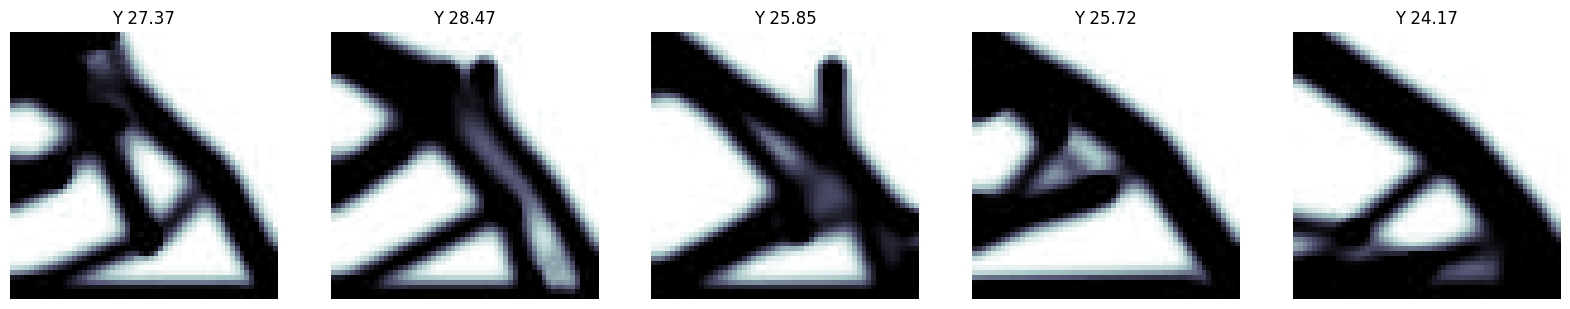

In [ ]:
# display images
fig = plt.figure(figsize=(20,10))
nplot = 5

for i in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,i)
    ax.imshow(X[i, :, :],cmap = plt.cm.bone)
    ax.set_title(f"Y {Y[i]:.2f}")
    ax.axis('off')
plt.show()

## 5. Define dataloader

In [ ]:
# 데이터를 학습용(80%)과 테스트용(20%)으로 나누기
# test set은 나중에 모델이 잘 학습됐는지 검증(validation)용으로 사용 가능
train_images, test_images, train_labels, test_labels = train_test_split(
    X, Y,                 # X: 이미지 데이터, Y: 레이블(정답)
    test_size=0.2,        # 전체 데이터 중 20%를 test set으로
    random_state=1,       # 랜덤 분할 시 같은 결과 나오도록 고정
    shuffle=True          # 데이터를 섞어서 나누기
)

# 학습/테스트 이미지와 라벨의 크기(행렬 shape)와 자료형 출력
print(np.shape(train_images), np.shape(test_images))
print(type(train_images), type(test_images))

print(np.shape(train_labels), np.shape(test_labels))
print(type(train_labels), type(test_labels))


# (image, image) 형태의 2차원 이미지를
# 1차원 벡터로 펼침 (예: 56x56 이미지를 3136차원 벡터로)
# np.prod(train_images.shape[1:]) → 이미지 하나의 전체 픽셀 수
train_images = train_images.reshape(
    (len(train_images), np.prod(train_images.shape[1:]))
).astype('float32')   # float32로 변환 (PyTorch에서 자주 쓰는 자료형)

test_images = test_images.reshape(
    (len(test_images), np.prod(test_images.shape[1:]))
).astype('float32')

print("Datasets_train_shape:{}  Datasets_test_shape:{}".format(
    np.shape(train_images), np.shape(test_images))
)


# numpy 배열을 PyTorch Tensor로 변환 (모델에 넣기 위해 필요)
train_images = torch.tensor(train_images, dtype=torch.float32).to(device)  # GPU/CPU로 이동
train_labels = torch.tensor(train_labels, dtype=torch.float32)             # 레이블도 tensor로 변환 (GPU 이동 안 함)
test_images = torch.tensor(test_images, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_labels, dtype=torch.float32)               # 마찬가지로 레이블만 변환

(2400, 56, 56) (600, 56, 56)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2400,) (600,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Datasets_train_shape:(2400, 3136)  Datasets_test_shape:(600, 3136)


## 6. Set to model architecture

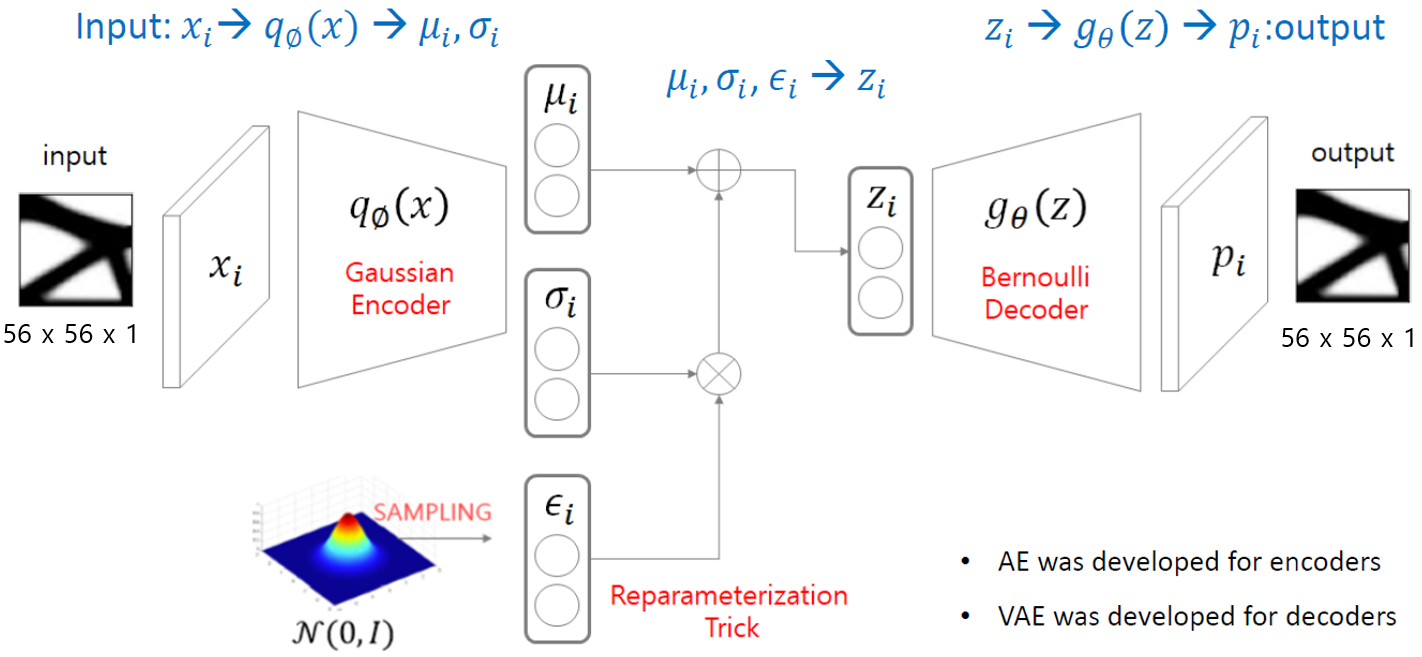

https://taeu.github.io/paper/deeplearning-paper-vae/

In [ ]:
# Encoder 정의 (nn.Module을 상속받아서 PyTorch 모델 모듈로 사용)
class Encoder(nn.Module):
    def __init__(self, input_dim, intermediate_dim, latent_dim):
        super(Encoder, self).__init__()

        # input_dim → intermediate_dim 으로 가는 첫 번째 은닉층(Linear Layer)
        # 예: 3136(56x56 이미지) → 512
        self.fc1 = nn.Linear(input_dim, intermediate_dim)

        # 잠재 공간(latent space)으로 보내기 위해 두 가지 출력을 준비
        # 1) 평균(mean) → 잠재 분포의 중심
        self.fc2_mean = nn.Linear(intermediate_dim, latent_dim)

        # 2) 로그 분산(log variance) → 잠재 분포의 퍼짐 정도
        self.fc2_logvar = nn.Linear(intermediate_dim, latent_dim)


    # forward: 입력 데이터를 받아서 출력까지 계산하는 함수 (PyTorch 규칙)
    def forward(self, x):
        # 첫 번째 층 통과 → ReLU 활성화 (비선형성 부여)
        h = torch.relu(self.fc1(x))

        # 은닉층 h를 통해 평균 벡터 생성
        z_mean = self.fc2_mean(h)      # latent 분포의 평균 (중심 좌표)

        # 은닉층 h를 통해 로그 분산 벡터 생성
        z_logvar = self.fc2_logvar(h)  # latent 분포의 log(분산)

        # Encoder는 평균과 분산을 모두 반환
        # → 이후 reparameterization trick을 통해 샘플링에 사용됨
        return z_mean, z_logvar


In [ ]:
# Decoder 정의 (nn.Module을 상속)
class Decoder(nn.Module):
    def __init__(self, latent_dim, intermediate_dim, output_dim):
        super(Decoder, self).__init__()

        # 잠재 공간(latent space)에서 은닉층으로 확장
        # latent_dim → intermediate_dim
        self.fc1 = nn.Linear(latent_dim, intermediate_dim)

        # 은닉층에서 최종 출력(원래 이미지 크기)으로 복원
        # intermediate_dim → output_dim (예: 3136 = 56x56 픽셀)
        self.fc2 = nn.Linear(intermediate_dim, output_dim)


    def forward(self, z):
        # 1. 잠재 벡터 z를 은닉층으로 변환 + ReLU 활성화
        h = torch.relu(self.fc1(z))

        # 2. 은닉층 h를 출력층으로 변환
        # Sigmoid 활성화 함수 사용 → 결과가 [0,1] 범위로 나오도록
        #   (이미지 픽셀은 보통 0~1 범위로 정규화하기 때문)
        x_recon = torch.sigmoid(self.fc2(h))  # 정규화된 픽셀값: 0~1사이기때문에 sigmoid사용 (컬러면 sigmoid나 tanh)

        # 3. 복원된 이미지(벡터 형태) 반환
        return x_recon


In [ ]:
# VAE 전체 모델 정의 (Encoder + Decoder 포함)
class VAE(nn.Module):
    def __init__(self, input_dim, intermediate_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder: 입력 데이터를 잠재 공간(latent space) 분포로 압축
        self.encoder = Encoder(input_dim, intermediate_dim, latent_dim)

        # Decoder: 잠재 공간의 벡터를 다시 원래 데이터 차원으로 복원
        self.decoder = Decoder(latent_dim, intermediate_dim, input_dim)


    # Reparameterization Trick
    # → 평균과 분산으로 정의된 분포에서 직접 샘플링하지 않고,
    #   난수 epsilon을 이용해서 샘플링 과정을 "미분 가능하게" 바꿈
    def reparameterize(self, z_mean, z_logvar):
        # epsilon: 표준정규분포(평균 0, 분산 1)에서 무작위 샘플링
        epsilon = torch.randn_like(z_mean)

        # z = 평균 + 표준편차 * epsilon
        # torch.exp(0.5 * z_logvar): 분산 -> 표준편차로 변환
        return z_mean + torch.exp(0.5 * z_logvar) * epsilon


    # forward: 모델이 입력 데이터를 받아서 출력까지 계산하는 과정
    def forward(self, x):
        # 1. Encoder로부터 평균과 로그분산을 얻음
        z_mean, z_logvar = self.encoder(x)

        # 2. reparameterization trick을 사용해 잠재 벡터 z를 샘플링
        z = self.reparameterize(z_mean, z_logvar)

        # 3. Decoder를 통해 z를 원래 데이터(이미지)로 복원
        x_recon = self.decoder(z)

        # 4. 복원된 이미지와 latent 분포의 평균/분산을 반환
        #    (손실 계산 시 reconstruction loss + KL divergence에 사용됨)
        return x_recon, z_mean, z_logvar


## 7. Set model hyperparameters

In [ ]:
# model architecture parameters
input_dim = train_images.shape[1]  # flattened image size (56*56 = 3136)
intermediate_dim = 512  # hidden layer dimension
latent_dim = 2  # latent space dimension (z-dim)

# training parameters
num_epochs = 300
batch_size = 20
learning_rate = 1e-3

In [ ]:
vae = VAE(input_dim, intermediate_dim, latent_dim).to(device)

# print the model summary
summary(vae, (input_dim,))

vae

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,606,144
            Linear-2                    [-1, 2]           1,026
            Linear-3                    [-1, 2]           1,026
           Encoder-4         [[-1, 2], [-1, 2]]               0
            Linear-5                  [-1, 512]           1,536
            Linear-6                 [-1, 3136]       1,608,768
           Decoder-7                 [-1, 3136]               0
Total params: 3,218,500
Trainable params: 3,218,500
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 12.28
Estimated Total Size (MB): 12.35
----------------------------------------------------------------


VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=3136, out_features=512, bias=True)
    (fc2_mean): Linear(in_features=512, out_features=2, bias=True)
    (fc2_logvar): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=3136, bias=True)
  )
)

## 8. Train model

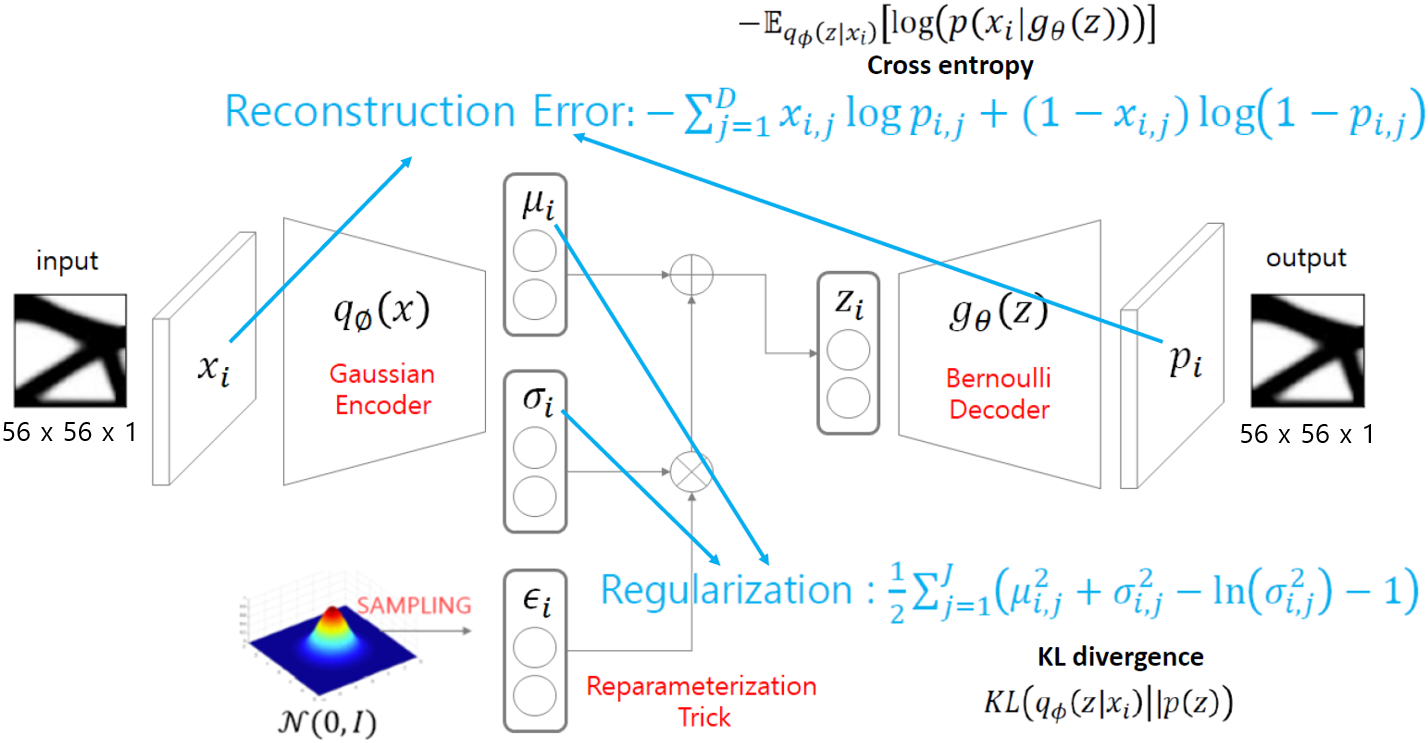

https://taeu.github.io/paper/deeplearning-paper-vae/

Epoch [1/300], Train_loss: 1.7246


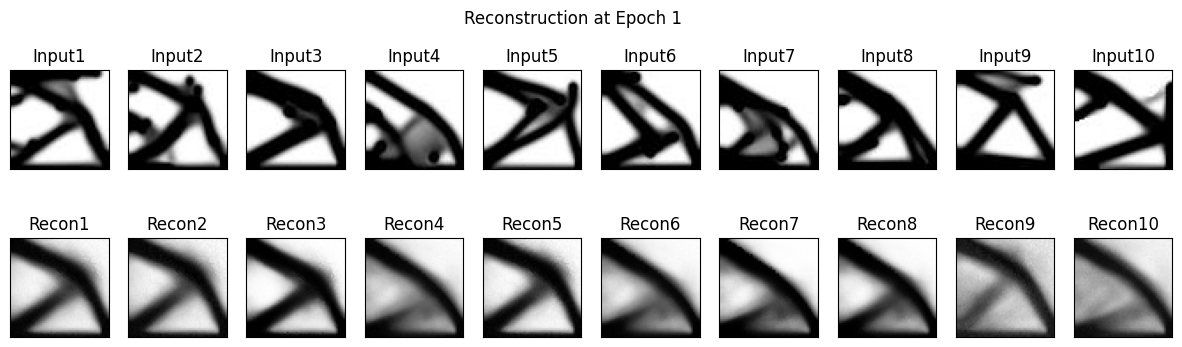

Epoch [2/300], Train_loss: 1.4451
Epoch [3/300], Train_loss: 1.4129
Epoch [4/300], Train_loss: 1.3907
Epoch [5/300], Train_loss: 1.3747
Epoch [6/300], Train_loss: 1.3569
Epoch [7/300], Train_loss: 1.3521
Epoch [8/300], Train_loss: 1.3472
Epoch [9/300], Train_loss: 1.3353
Epoch [10/300], Train_loss: 1.3291
Epoch [11/300], Train_loss: 1.3250
Epoch [12/300], Train_loss: 1.3177
Epoch [13/300], Train_loss: 1.3135
Epoch [14/300], Train_loss: 1.3076
Epoch [15/300], Train_loss: 1.3119
Epoch [16/300], Train_loss: 1.2965
Epoch [17/300], Train_loss: 1.2950
Epoch [18/300], Train_loss: 1.2882
Epoch [19/300], Train_loss: 1.2894
Epoch [20/300], Train_loss: 1.2792
Epoch [21/300], Train_loss: 1.2789
Epoch [22/300], Train_loss: 1.2697
Epoch [23/300], Train_loss: 1.2669
Epoch [24/300], Train_loss: 1.2645
Epoch [25/300], Train_loss: 1.2630
Epoch [26/300], Train_loss: 1.2620
Epoch [27/300], Train_loss: 1.2576
Epoch [28/300], Train_loss: 1.2575
Epoch [29/300], Train_loss: 1.2515
Epoch [30/300], Train_loss: 

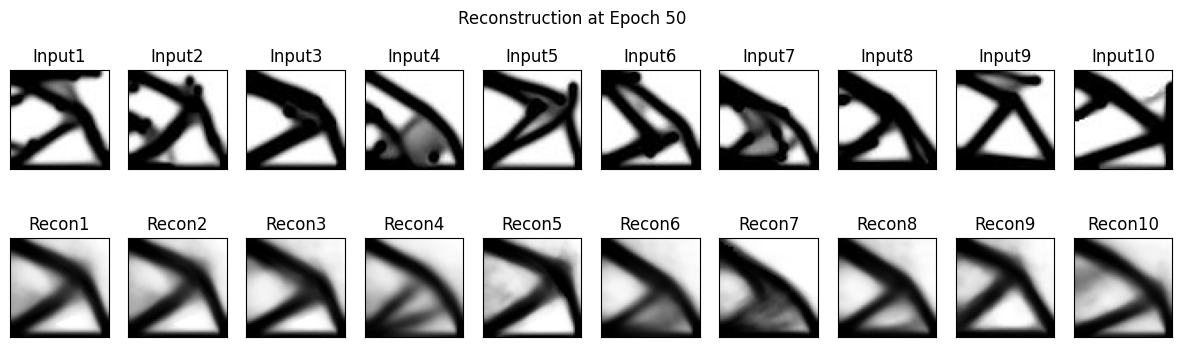

Epoch [51/300], Train_loss: 1.2076
Epoch [52/300], Train_loss: 1.2099
Epoch [53/300], Train_loss: 1.2088
Epoch [54/300], Train_loss: 1.2093
Epoch [55/300], Train_loss: 1.2028
Epoch [56/300], Train_loss: 1.2002
Epoch [57/300], Train_loss: 1.2062
Epoch [58/300], Train_loss: 1.1979
Epoch [59/300], Train_loss: 1.1993
Epoch [60/300], Train_loss: 1.1962
Epoch [61/300], Train_loss: 1.1962
Epoch [62/300], Train_loss: 1.1950
Epoch [63/300], Train_loss: 1.1939
Epoch [64/300], Train_loss: 1.1960
Epoch [65/300], Train_loss: 1.1919
Epoch [66/300], Train_loss: 1.1926
Epoch [67/300], Train_loss: 1.1887
Epoch [68/300], Train_loss: 1.1941
Epoch [69/300], Train_loss: 1.1874
Epoch [70/300], Train_loss: 1.1826
Epoch [71/300], Train_loss: 1.1940
Epoch [72/300], Train_loss: 1.1847
Epoch [73/300], Train_loss: 1.1848
Epoch [74/300], Train_loss: 1.1831
Epoch [75/300], Train_loss: 1.1787
Epoch [76/300], Train_loss: 1.1795
Epoch [77/300], Train_loss: 1.1812
Epoch [78/300], Train_loss: 1.1797
Epoch [79/300], Trai

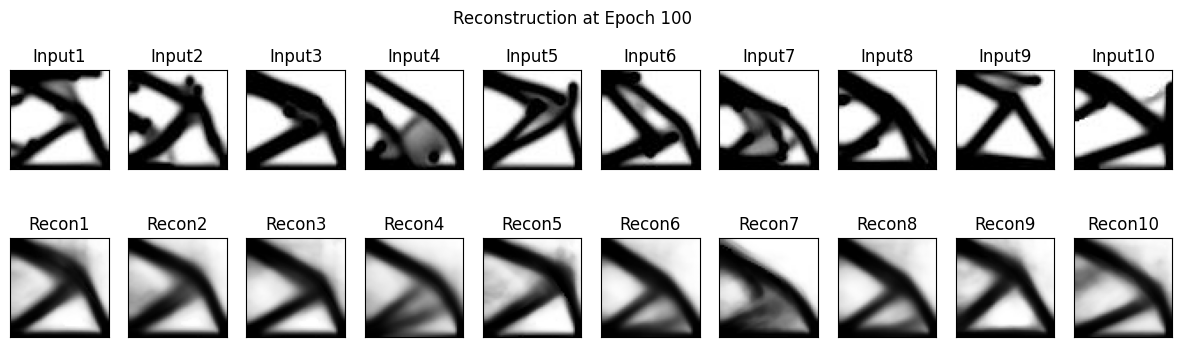

Epoch [101/300], Train_loss: 1.1586
Epoch [102/300], Train_loss: 1.1614
Epoch [103/300], Train_loss: 1.1584
Epoch [104/300], Train_loss: 1.1586
Epoch [105/300], Train_loss: 1.1581
Epoch [106/300], Train_loss: 1.1579
Epoch [107/300], Train_loss: 1.1587
Epoch [108/300], Train_loss: 1.1556
Epoch [109/300], Train_loss: 1.1558
Epoch [110/300], Train_loss: 1.1587
Epoch [111/300], Train_loss: 1.1623
Epoch [112/300], Train_loss: 1.1522
Epoch [113/300], Train_loss: 1.1551
Epoch [114/300], Train_loss: 1.1522
Epoch [115/300], Train_loss: 1.1540
Epoch [116/300], Train_loss: 1.1495
Epoch [117/300], Train_loss: 1.1519
Epoch [118/300], Train_loss: 1.1563
Epoch [119/300], Train_loss: 1.1520
Epoch [120/300], Train_loss: 1.1522
Epoch [121/300], Train_loss: 1.1481
Epoch [122/300], Train_loss: 1.1494
Epoch [123/300], Train_loss: 1.1472
Epoch [124/300], Train_loss: 1.1460
Epoch [125/300], Train_loss: 1.1528
Epoch [126/300], Train_loss: 1.1484
Epoch [127/300], Train_loss: 1.1490
Epoch [128/300], Train_loss:

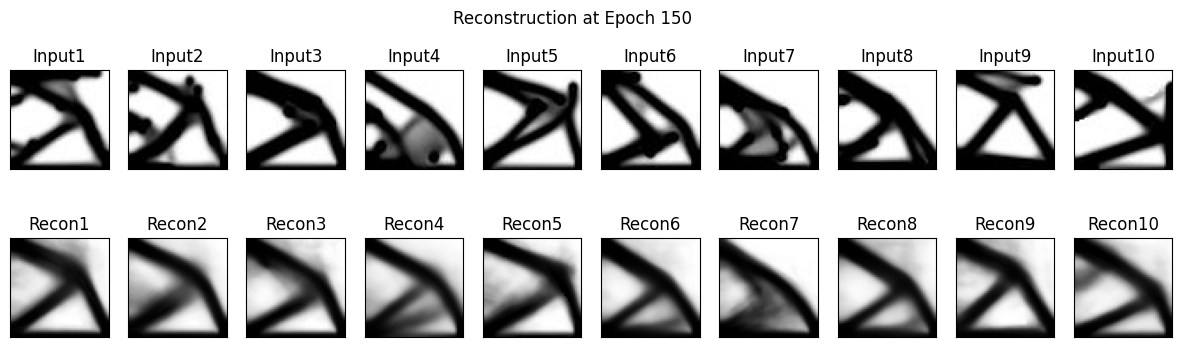

Epoch [151/300], Train_loss: 1.1360
Epoch [152/300], Train_loss: 1.1359
Epoch [153/300], Train_loss: 1.1353
Epoch [154/300], Train_loss: 1.1327
Epoch [155/300], Train_loss: 1.1352
Epoch [156/300], Train_loss: 1.1341
Epoch [157/300], Train_loss: 1.1344
Epoch [158/300], Train_loss: 1.1268
Epoch [159/300], Train_loss: 1.1329
Epoch [160/300], Train_loss: 1.1318
Epoch [161/300], Train_loss: 1.1294
Epoch [162/300], Train_loss: 1.1378
Epoch [163/300], Train_loss: 1.1297
Epoch [164/300], Train_loss: 1.1245
Epoch [165/300], Train_loss: 1.1340
Epoch [166/300], Train_loss: 1.1310
Epoch [167/300], Train_loss: 1.1263
Epoch [168/300], Train_loss: 1.1222
Epoch [169/300], Train_loss: 1.1257
Epoch [170/300], Train_loss: 1.1253
Epoch [171/300], Train_loss: 1.1295
Epoch [172/300], Train_loss: 1.1337
Epoch [173/300], Train_loss: 1.1280
Epoch [174/300], Train_loss: 1.1236
Epoch [175/300], Train_loss: 1.1273
Epoch [176/300], Train_loss: 1.1219
Epoch [177/300], Train_loss: 1.1275
Epoch [178/300], Train_loss:

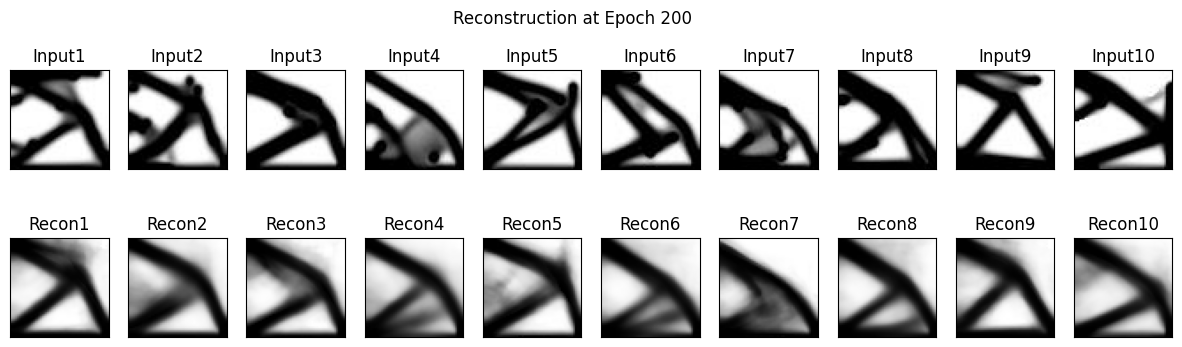

Epoch [201/300], Train_loss: 1.1205
Epoch [202/300], Train_loss: 1.1205
Epoch [203/300], Train_loss: 1.1193
Epoch [204/300], Train_loss: 1.1154
Epoch [205/300], Train_loss: 1.1123
Epoch [206/300], Train_loss: 1.1168
Epoch [207/300], Train_loss: 1.1214
Epoch [208/300], Train_loss: 1.1074
Epoch [209/300], Train_loss: 1.1154
Epoch [210/300], Train_loss: 1.1125
Epoch [211/300], Train_loss: 1.1108
Epoch [212/300], Train_loss: 1.1091
Epoch [213/300], Train_loss: 1.1111
Epoch [214/300], Train_loss: 1.1113
Epoch [215/300], Train_loss: 1.1159
Epoch [216/300], Train_loss: 1.1188
Epoch [217/300], Train_loss: 1.1077
Epoch [218/300], Train_loss: 1.1116
Epoch [219/300], Train_loss: 1.1117
Epoch [220/300], Train_loss: 1.1108
Epoch [221/300], Train_loss: 1.1090
Epoch [222/300], Train_loss: 1.1107
Epoch [223/300], Train_loss: 1.1102
Epoch [224/300], Train_loss: 1.1062
Epoch [225/300], Train_loss: 1.1089
Epoch [226/300], Train_loss: 1.1051
Epoch [227/300], Train_loss: 1.1087
Epoch [228/300], Train_loss:

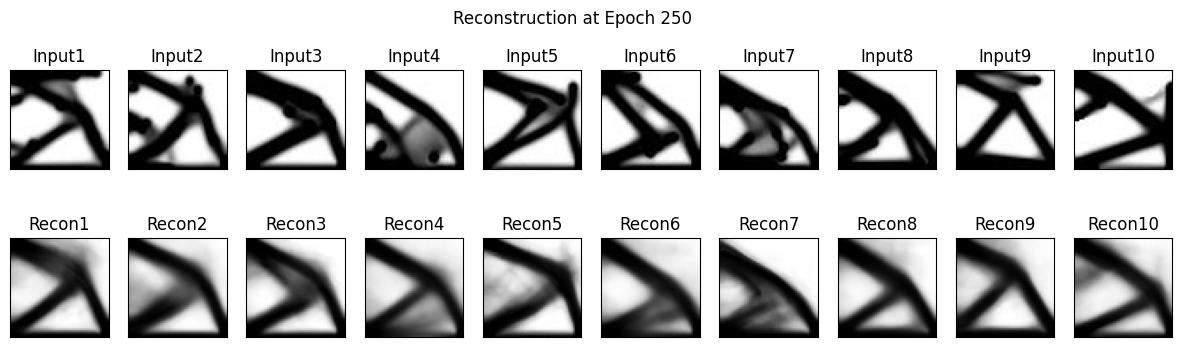

Epoch [251/300], Train_loss: 1.1048
Epoch [252/300], Train_loss: 1.1003
Epoch [253/300], Train_loss: 1.1036
Epoch [254/300], Train_loss: 1.0998
Epoch [255/300], Train_loss: 1.0998
Epoch [256/300], Train_loss: 1.1041
Epoch [257/300], Train_loss: 1.1035
Epoch [258/300], Train_loss: 1.0977
Epoch [259/300], Train_loss: 1.0967
Epoch [260/300], Train_loss: 1.1012
Epoch [261/300], Train_loss: 1.0973
Epoch [262/300], Train_loss: 1.0946
Epoch [263/300], Train_loss: 1.1020
Epoch [264/300], Train_loss: 1.0951
Epoch [265/300], Train_loss: 1.0963
Epoch [266/300], Train_loss: 1.0942
Epoch [267/300], Train_loss: 1.1003
Epoch [268/300], Train_loss: 1.0986
Epoch [269/300], Train_loss: 1.0934
Epoch [270/300], Train_loss: 1.1038
Epoch [271/300], Train_loss: 1.0956
Epoch [272/300], Train_loss: 1.0945
Epoch [273/300], Train_loss: 1.0933
Epoch [274/300], Train_loss: 1.0937
Epoch [275/300], Train_loss: 1.0964
Epoch [276/300], Train_loss: 1.0919
Epoch [277/300], Train_loss: 1.0955
Epoch [278/300], Train_loss:

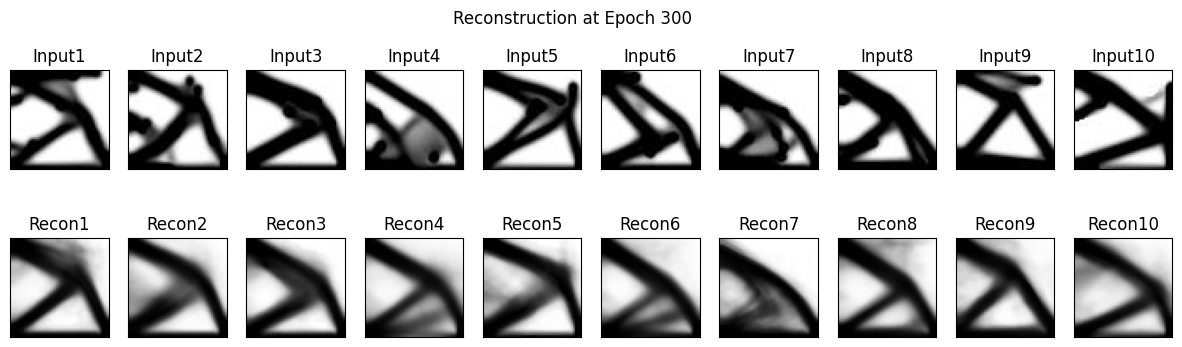

In [ ]:
# 학습용 DataLoader 만들기
# Autoencoder는 입력과 출력이 동일 → label 불필요 (그래서 (x, x) 구조로 저장)
train_dataset = TensorDataset(train_images, train_images)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# Optimizer & Loss function 설정 -----------------------

# 최적화 알고리즘(optimizer) 정의
# Adam: SGD(확률적 경사하강법)보다 빠르고 안정적으로 학습되는 알고리즘
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)


# VAE 손실 함수 정의
def vae_loss(x, x_recon, z_mean, z_logvar):

    image_size = x.shape[1]  # 이미지 전체 픽셀 수 (예: 56x56=3136)

    # 1) Reconstruction Loss (재구성 손실)
    # 입력 x와 복원된 x_recon이 얼마나 비슷한지 측정
    # 데이터가 이진(binary)라면 BCE Loss가 적합
    # recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
    # 여기서는 연속형 데이터 → MSE Loss 사용
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum')

    # 2) Regularization Loss (KL Divergence)
    # 잠재 분포 z가 표준정규분포 N(0,1)에 가깝도록 강제
    regul_loss = 0.5 * torch.sum(z_mean.pow(2) + z_logvar.exp() - z_logvar - 1)

    # 총 손실 = 재구성 손실 + KL 발산
    # 픽셀 개수(image_size)로 나눠서 정규화
    total_loss = (recon_loss + regul_loss) / image_size

    return total_loss


# 학습 기록 저장용 리스트
loss_train_history = []


# ------------------- VAE 학습 루프 -------------------
for epoch in range(num_epochs):
    vae.train()  # 학습 모드 켜기
    total_loss = 0.0

    for x, _ in train_loader:  # DataLoader에서 배치(batch) 단위로 데이터 꺼내오기
        optimizer.zero_grad()  # gradient 초기화
        x_recon, z_mean, z_logvar = vae(x)  # 입력 → VAE → 출력
        loss = vae_loss(x, x_recon, z_mean, z_logvar)  # 손실 계산
        loss.backward()  # 역전파로 gradient 계산
        optimizer.step()  # 가중치 업데이트

        total_loss += loss.item()  # 배치 손실 합산

    # 1 epoch이 끝났을 때 평균 손실 계산
    average_loss_train = total_loss / len(train_loader)

    # 손실 기록 저장
    loss_train_history.append(average_loss_train)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train_loss: {average_loss_train:.4f}")


    # 일정 주기마다 재구성 결과 확인 (inference)
    if (epoch + 1) % 50 == 0 or epoch == 0:
        vae.eval()  # 평가 모드로 전환 (dropout, batchnorm 등 비활성화)
        recon_x_test, _, _ = vae(test_images)  # test 이미지 넣어서 복원 결과 얻기

        n = 10  # 몇 개의 이미지를 보여줄지
        plt.figure(figsize=(15, 4)) # 그림 크기 설정

        for i in range(n):
            # (1) 원본 이미지 출력
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(test_images.cpu()[i].reshape(56, 56), vmin=0, vmax=1, cmap="gray")
            plt.title(f"Input{i+1}")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # (2) 복원된 이미지 출력
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(recon_x_test.detach().cpu()[i].reshape(56, 56), vmin=0, vmax=1, cmap="gray")
            plt.title(f"Recon{i+1}")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.suptitle(f"Reconstruction at Epoch {epoch+1}")  # 전체 제목
        plt.show()
        vae.train()  # 다시 학습 모드로 전환


# 학습이 끝난 후 모델 저장 (가중치만 저장)
torch.save(vae.state_dict(), 'VAE_model.pth')


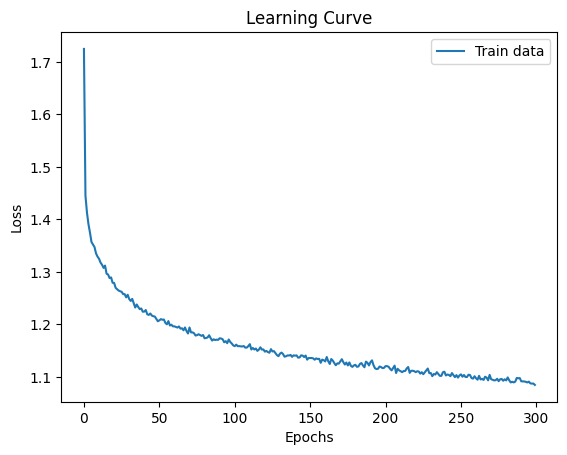

In [ ]:
# graph visualization
plot_loss(loss_train_history, 'Learning Curve')  # loss variation over epochs during training
plt.show()

## 9. Load & Evaluate model

- Compare the orginial image and the reconstructed image

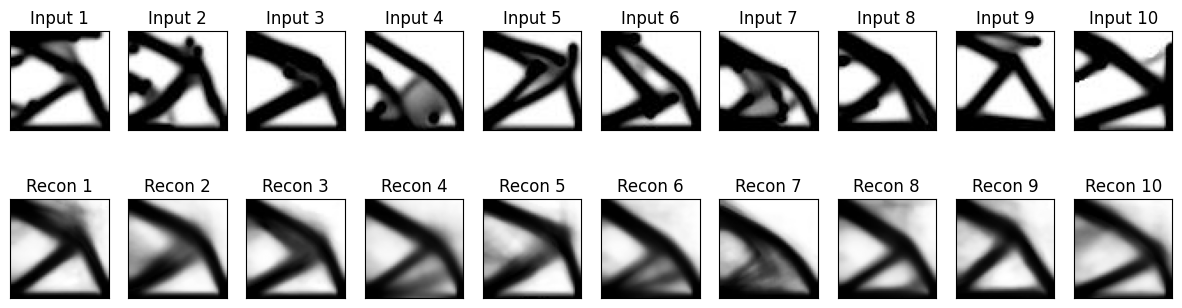

In [ ]:
# set the model to evaluation mode (no gradients will be computed)
vae.eval()

# reconstruct the test images using the trained VAE
with torch.no_grad():
    recon_x_test, _, _ = vae(test_images)

# visualize the original and reconstructed images

n = 10  # how many images to display

plt.figure(figsize=(15, 4)) # figure size

for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images.cpu()[i].reshape(56, 56), vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title(f"Input {i+1}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test.cpu()[i].reshape(56, 56), vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title(f"Recon {i+1}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

- Plot latent space (2D) manifold